In [6]:
import torch, timm, json, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix)
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from pathlib import Path

In [7]:
class CFG:
    seed        = 42
    img_size    = 299
    batch_size  = 32 
    mean        = (0.485, 0.456, 0.406)
    std         = (0.229, 0.224, 0.225)
    LABELS      = ["Unripe","Early Ripening","Ripe","Fully Ripe","Overripe"]
    num_classes = len(LABELS)
    device      = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    base_model  = "inception_v3"

CHECKPOINTS = {
    #"baseline"    : "baseline.pt", 
    "inceptionv3_model" : "inceptionv3_model.pt",
    #"last_model"  : "last_model.pt",
}

DATA_ROOT = Path("./data/processed_data/")

In [8]:
tf = transforms.Compose([
    transforms.Resize((CFG.img_size, CFG.img_size)),
    transforms.ToTensor(), transforms.Normalize(CFG.mean, CFG.std)
])
full_ds = datasets.ImageFolder(DATA_ROOT, transform=tf)

n_total = len(full_ds)
n_test  = int(0.10 * n_total)
n_val   = int(0.10 * n_total)
n_train = n_total - n_val - n_test

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(CFG.seed)
)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False,
                         num_workers=2, pin_memory=torch.cuda.is_available())

In [9]:
def build_model():
    return timm.create_model(
        CFG.base_model, pretrained=False,
        num_classes=CFG.num_classes).to(CFG.device)

def evaluate_ckpt(name, ckpt_path):
    print(f"\n=== Evaluating {name} ===")
    model = build_model()
    model.load_state_dict(torch.load(ckpt_path, map_location=CFG.device))
    model.eval()

    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(CFG.device)
            y_true += y.tolist()
            y_pred += model(X).argmax(1).cpu().tolist()

    # ---- overall accuracy ----
    acc = accuracy_score(y_true, y_pred)
    print(f"\nOverall accuracy: {acc:.4f}")

    # ---- metrics ----
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(CFG.num_classes)), zero_division=0)
    metrics_df = pd.DataFrame({
        "Precision": prec, "Recall": rec, "F1": f1
    }, index=CFG.LABELS)
    print(metrics_df.round(3))

    # macro / weighted
    overall = classification_report(
        y_true, y_pred, target_names=CFG.LABELS,
        digits=3, zero_division=0)
    print("\nMacro / weighted:\n", overall)

    # ---- confusion matrix ----
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CFG.LABELS, yticklabels=CFG.LABELS)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{name} – Confusion Matrix (test)")
    plt.tight_layout()
    plt.show()



=== Evaluating inceptionv3_model ===

Overall accuracy: 0.9815
                Precision  Recall     F1
Unripe              0.971   0.975  0.973
Early Ripening      0.984   0.957  0.970
Ripe                1.000   0.998  0.999
Fully Ripe          0.956   0.984  0.970
Overripe            0.993   0.989  0.991

Macro / weighted:
                 precision    recall  f1-score   support

        Unripe      0.971     0.975     0.973       278
Early Ripening      0.984     0.957     0.970       394
          Ripe      1.000     0.998     0.999       449
    Fully Ripe      0.956     0.984     0.970       442
      Overripe      0.993     0.989     0.991       441

      accuracy                          0.982      2004
     macro avg      0.981     0.980     0.981      2004
  weighted avg      0.982     0.982     0.982      2004



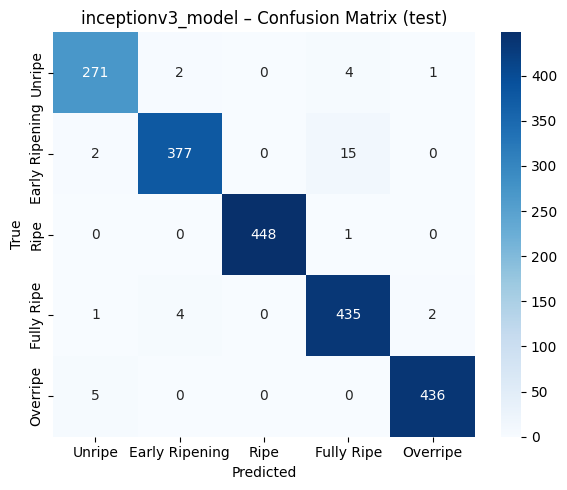

In [10]:
for name, path in CHECKPOINTS.items():
    evaluate_ckpt(name, path)